In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime
import numpy as np
import pymc3 as pm

We present a case study of stochastic volatility, time varying stock market volatility, to illustrate PyMC3’s use in addressing a more realistic problem. The distribution of market returns is highly non-normal, which makes sampling the volatilities significantly more difficult. This example has 400+ parameters so using common sampling algorithms like Metropolis-Hastings would get bogged down, generating highly autocorrelated samples. Instead, we use NUTS, which is dramatically more efficient.

# The Model

Asset prices have time-varying volatility (variance of day over day returns). In some periods, returns are highly variable, while in others they are very stable. Stochastic volatility models address this with a latent volatility variable, which changes over time. The following model is similar to the one described in the NUTS paper (Hoffman 2014, p. 21).

$$\begin{aligned}\sigma &\sim exp(50)\\ \nu &\sim exp(.1)\\
s_i &\sim \cal{N}(s_{i-1}, \sigma^{-2})\\
log(y_i) &\sim t(\nu, 0, exp(-2s_i))
\end{aligned}$$

Here, $y$ is the daily return series which is modeled with a Student-t distribution with an unknown degrees of freedom parameter, and a scale parameter determined by a latent process $s$. The individual $s_i$ are the individual daily log volatilities in the latent log volatility process.

# The Data

Our data consists of daily returns of the S&P 500 during the 2008 financial crisis. Here, we use ``pandas-datareader`` to obtain the price data from Yahoo!-Finance.

In [27]:
# returns = pd.read_csv('./all_stocks_1yr.csv', index_col='Date')['Close'].pct_change()
# returns.plot(figsize=(10,6));

In [65]:
start = datetime(2008,5,1)
end = datetime(2009, 12, 1)
f = web.DataReader('SPY', 'morningstar', start, end)

In [74]:
f = f.reset_index().drop('Symbol', axis=1).set_index('Date')

In [75]:
returns = f['Close'].pct_change()

Text(0,0.5,'daily returns in %')

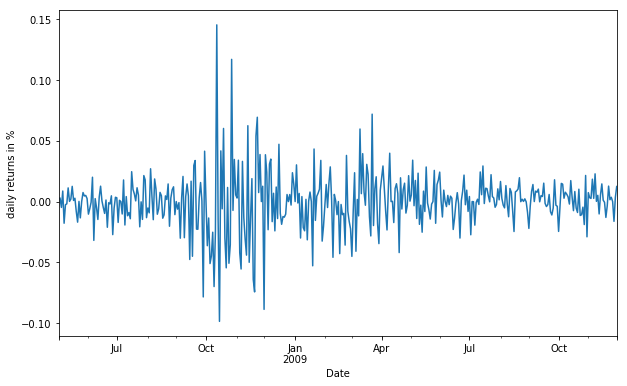

In [76]:
returns.plot(figsize=(10,6))
plt.ylabel('daily returns in %')

# Model specification

In [79]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1./10, testval=5.)
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)

    s = pm.GaussianRandomWalk('s', sigma**-2, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s))

    r = pm.StudentT('r', nu, lam=1/volatility_process, observed=returns)

# Fitting

In [80]:
with sp500_model:
    trace = pm.sample(2000)

/usr/local/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [03:08<00:00, 13.25it/s]


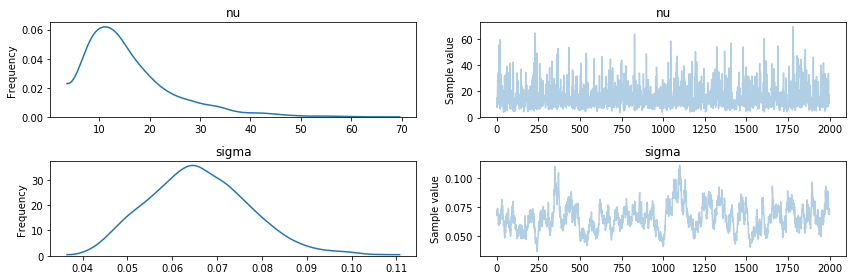

In [81]:
pm.traceplot(trace, [nu, sigma]);


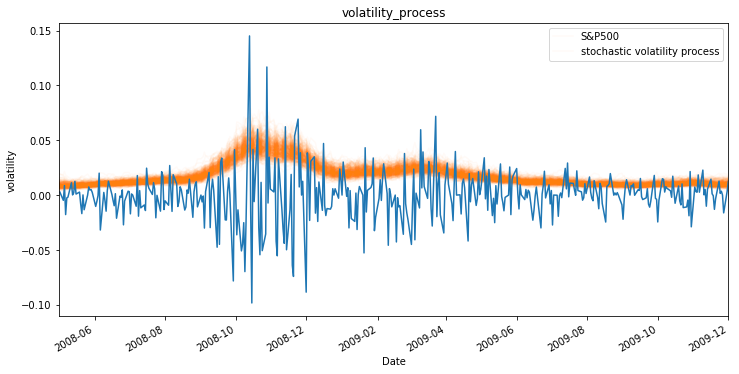

In [99]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'C1', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
returns.plot(ax=ax)
ax.legend(['S&P500', 'stochastic volatility process'])

In [101]:
pm.GaussianRandomWalk?